# Rising Sea Levels of New York City

1. Introduction
2. Mapping NYC Sea Level Trends
3. Corporations and New York City on Sea Level Rise
4. Flood Vulnerability Analysis
5. Executive Summary and Future Work

## 1. Introduction 

Global Sea levels are rising at an accelerating at an alarming rate all around the world, and the scientific community is in consensus that Global Warming is the major cause for this increase. 

Sea level rise is caused primarily by two factors related to global warming: the added water from melting ice sheets and glaciers and the expansion of seawater as it warms. 

The first graph tracks the change in mean sea level from 1870 to 2013 as observed by satellites.

The second graph is a boxplot showing the variability in mean sea levels over the past 3 Centuries.

In [ ]:
!pip install area
!pip install wordcloud
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import geopandas as gpd
import folium
import shapely.speedups
from folium.plugins import FastMarkerCluster
import plotly.graph_objects as go # or plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
# import pandas_read_xml as pdx
import json
import math
from area import area
from sklearn import neighbors
from wordcloud import WordCloud, STOPWORDS
import re 
from textblob import TextBlob 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer



# Offline mode
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly.offline import iplot as ip

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Data for Global Sea Levels
gsl = pd.read_csv('../input/sea-level-change/sea_levels_2015.csv', error_bad_lines=False)

# CDC Corporte Climate Change Data
corp20 = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2020_Full_Climate_Change_Dataset.csv')
corp19 = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2019_Full_Climate_Change_Dataset.csv')
corp18 = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2018_Full_Climate_Change_Dataset.csv')

corp_meta = pd.read_csv("../input/cdp-unlocking-climate-solutions/Supplementary Data/Locations of Corporations/NA_HQ_public_data.csv")
corp20_dis = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Disclosing/Climate Change/2020_Corporates_Disclosing_to_CDP_Climate_Change.csv')
corp20_dis = corp20_dis[['account_number', 'organization', 'country', 'primary_activity', 'primary_sector', 'primary_industry']]

corp20 = pd.merge(left=corp20, right=corp_meta,  left_on=['account_number'], right_on = ['account_number'])
corp20_dis = pd.merge(left=corp20_dis, right=corp_meta,  left_on=['account_number'], right_on = ['account_number'])

In [ ]:
# Global Sea Level
gsl_data = go.Scatter(x=gsl['Time'],y=gsl['GMSL'])
gsl_data_1 = go.Scatter(x=gsl['Time'],y=gsl['GMSL uncertainty'])

layout = go.Layout(title='Rising Global Sea Levels', title_x=0.5, xaxis=dict(title='Year'),yaxis=dict(title='Global Mean Sea Level (GMSL) (mm)'),template='plotly_dark')
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
   x=gsl['Time'],y=gsl['GMSL'],
    name="GMSL"
))
fig.add_trace(go.Scatter(
   x=gsl['Time'],y=gsl['GMSL uncertainty'],
    name="GMSL Uncertainty"
))
ip(fig)

In [ ]:
gsl["Year"] = gsl["Time"].str.slice(start=0, stop=4, step=1)# sns.boxplot(data=gsl, x="Century", y="GMSL");
gsl['Year'] = gsl['Year'].astype(int)
years = gsl['Year'].tolist()
def centuryFromYear(year):
    return (year + 99) // 100
Century = list(map(centuryFromYear, years))
gsl['Century'] = Century

In [ ]:
# df = px.data.tips()
fig = px.box(gsl, x="Century", y="GMSL", template='plotly_dark')
fig.show()

## 2. Tracking NYC Sea Level Trends 

Higher sea levels equate to more and higher coastal floods and New York City is at a particularly high risk. The New York City Panel on Climate Change has found that in the worst case there is a **3-in-4 chance of historically unprecedented coastal flooding in New York City by 2100** and in the best case scenario, given that the human race miraculously decreases their CO2 emissions, there is a 1-in-10 chance of the same.

Sea Level rise has already increased the likelihood of extreme flooding in **Lower Manhattan – flooding high enough to seriously threaten the subway system – by 50%.**

The map below is the 500-Year Floodplain for the 2050s based on FEMA's Preliminary Work Map data and the New York Panel on Climate Change's 90th Percentile Projects for Sea-Level Rise (31 inches). Data Provided by the Mayor's Office of Long-Term Planning and Sustainability (OLTPS) on behalf of CUNY Institute for Sustainable Cities (CISC) and the New York Panel on Climate Change (NPCC). 

The blue are represents land that is projected to be underwater in 2050

In [ ]:
rise = gpd.read_file('../input/new-york-city-sea-level-rise-map/Sea Level Rise NYC.geojson')

In [ ]:
m = folium.Map(location=[40.8990, -73.8885], zoom_start=9)
folium.GeoJson(
    rise,
    name='geojson',
).add_to(m)
folium.LayerControl().add_to(m)
m

120 square miles of land lie less than 6 feet above the high tide line in New York, the height of a statistically extreme flood. This land is home to nearly half a million New Yorkers, 21% of whom live in just three zip codes. $101 billion in property value sits on the same land, as do more than 1,500 miles of road, 1,200 EPA-listed sites, and 100 public schools.

These numbers nearly double when assessed at 9 feet above the high tide line – Sandy’s peak flood elevation as measured at the Battery in New York City. In Brooklyn and Manhattan, the most socially vulnerable populations are, respectively, about 30% and 80% more likely than the population as a whole to be flooded at this level.

In [ ]:
df = pd.read_csv('../input/nyc-data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
nycmap = json.load(open("../input/nyc-data/nyc_neighborhoods.geojson.json"))

In [ ]:
d = {}
neighborhood = nycmap["features"]
for n in neighborhood:
    code = n["properties"]["ntacode"]
    a = area(n["geometry"])/(1609*1609)
    d[code] = a

df["area"] = df["NTA Code"].map(d)
df = df.dropna(subset=["area"])
df["density"] = df["Population"]/df["area"]

fig = px.choropleth_mapbox(df,
                           geojson=nycmap,
                           locations="NTA Code",
                           featureidkey="properties.ntacode",
                           color="density",
                           color_continuous_scale="viridis",
                           mapbox_style="carto-positron",
                           zoom=9, center={"lat": 40.7, "lon": -73.9},
                           opacity=0.7,
                           hover_name="NTA Name", 
                           title="Population Density of NYC",
                           template='plotly_dark'
                           )
fig.show()

As shown below, 120 square miles of land lie less than 6 feet above the high tide line in New York, the height of a statistically extreme flood. This land is home to nearly half a million New Yorkers, 21% of whom live in just three zip codes. $101 billion in property value sits on the same land, as do more than 1,500 miles of road, 1,200 EPA-listed sites, and 100 public schools.

These numbers nearly double when assessed at 9 feet above the high tide line – Sandy’s peak flood elevation as measured at the Battery in New York City. In Brooklyn and Manhattan, the most socially vulnerable populations are, respectively, about 30% and 80% more likely than the population as a whole to be flooded at this level.

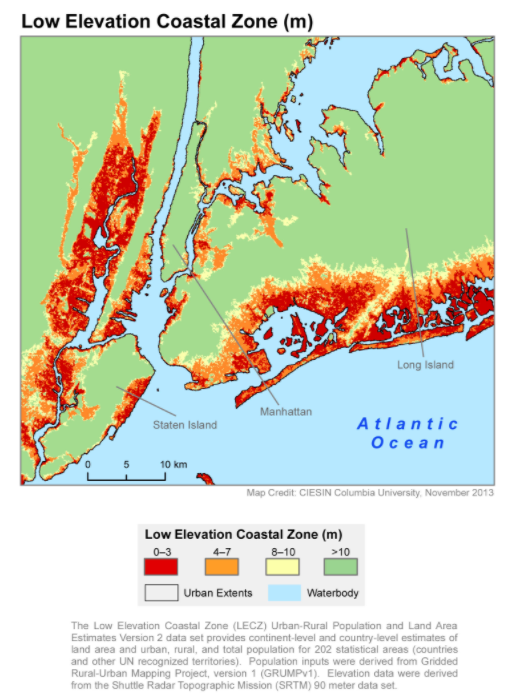

## 3. Corporations and New York City on flooding

In [ ]:
NY_corp_dis = corp20_dis[(corp20_dis['survey_name'] == 'Climate Change 2020') & (corp20_dis['address_city'] == 'New York')]

In [ ]:
#ax = sns.countplot(y="primary_sector", data=NY_corp_dis).set(title='Primary sectors of corporations in New York', ylabel='')
fig = px.bar(NY_corp_dis, x=NY_corp_dis['primary_sector'].value_counts().index, 
             y=NY_corp_dis['primary_sector'].value_counts().values,
             height=400,
            template='plotly_dark', 
            title="Primary Industries in NYC")

fig.show()

Finding the biggest hazards for the city and corporations

In [ ]:
# Getting all New York City specific corporations

nyc_corp20 = corp20[(corp20["address_city"] == 'New York') & (corp20["survey_name"] == 'Climate Change 2020')]
nyc_corp19 = corp20[(corp20["address_city"] == 'New York') & (corp20["survey_name"] == 'Climate Change 2019')]
nyc_corp18 = corp20[(corp20["address_city"] == 'New York') & (corp20["survey_name"] == 'Climate Change 2018')]

In [ ]:
# (C2.3) Have you identified any inherent climate-related risks with the potential to have a 
# substantive financial or strategic impact on your business?

# New York City in 2020
responses20_2_3 = pd.DataFrame()
responses20_2_3["organization"] = nyc_corp20[nyc_corp20["question_number"] == 'C2.3']["organization_x"]
responses20_2_3["response_to_2.3"] = nyc_corp20[nyc_corp20["question_number"] == 'C2.3']["response_value"]
responses20_2_3 = responses20_2_3.drop_duplicates()
response20_rate = sum(responses20_2_3["response_to_2.3"].value_counts().values)/len(responses20_2_3["organization"])*100
response20_rate_yes = responses20_2_3["response_to_2.3"].value_counts().values[0]/len(responses20_2_3["organization"])*100
response20_rate_no = responses20_2_3["response_to_2.3"].value_counts().values[1]/len(responses20_2_3["organization"])*100
response20_rate_nan = 100 - (response20_rate_yes + response20_rate_no)

x = ['Yes', 'No', 'No Response']
y = [responses20_2_3["response_to_2.3"].value_counts().values[0], 
     responses20_2_3["response_to_2.3"].value_counts().values[1], 
     len(responses20_2_3["organization"]) - (responses20_2_3["response_to_2.3"].value_counts().values[0] + responses20_2_3["response_to_2.3"].value_counts().values[1])]

fig = go.Figure(data=[go.Bar(x=x, y=y,
                             hovertext=[str(round(response20_rate_yes, 2))+'%', str(round(response20_rate_no, 2))+'%', str(round(response20_rate_nan, 2))+'%'], 
                             text=y,
                             textposition='auto',
                            )])
fig.update_layout(title_text="New York Organizations that identified climate-related risks to their business in 2020",template='plotly_dark')
fig.show()

# New York City in 2019
responses19_2_3 = pd.DataFrame()
responses19_2_3["organization"] = nyc_corp19[nyc_corp19["question_number"] == 'C2.3']["organization_x"]
responses19_2_3["response_to_2.3"] = nyc_corp19[nyc_corp19["question_number"] == 'C2.3']["response_value"]
responses19_2_3 = responses19_2_3.drop_duplicates()
response19_rate = sum(responses19_2_3["response_to_2.3"].value_counts().values)/len(responses19_2_3["organization"])*100
response19_rate_yes = responses19_2_3["response_to_2.3"].value_counts().values[0]/len(responses19_2_3["organization"])*100
response19_rate_no = responses19_2_3["response_to_2.3"].value_counts().values[1]/len(responses19_2_3["organization"])*100
response19_rate_nan = 100 - (response19_rate_yes + response19_rate_no)

x = ['Yes', 'No', 'No Response']
y = [responses19_2_3["response_to_2.3"].value_counts().values[0], 
     responses19_2_3["response_to_2.3"].value_counts().values[1], 
     len(responses19_2_3["organization"]) - (responses19_2_3["response_to_2.3"].value_counts().values[0] + responses19_2_3["response_to_2.3"].value_counts().values[1])]

fig = go.Figure(data=[go.Bar(x=x, y=y,
                             hovertext=[str(round(response19_rate_yes, 2))+'%', str(round(response19_rate_no, 2))+'%', str(round(response19_rate_nan, 2))+'%'], 
                             text=y,
                             textposition='auto',
                            )])
fig.update_layout(title_text="New York Organizations that identified climate-related risks to their business in 2019", template='plotly_dark')
fig.show()

# New York City in 2018
responses18_2_3 = pd.DataFrame()
responses18_2_3["organization"] = nyc_corp18[nyc_corp18["question_number"] == 'C2.3']["organization_x"]
responses18_2_3["response_to_2.3"] = nyc_corp18[nyc_corp18["question_number"] == 'C2.3']["response_value"]
responses18_2_3 = responses18_2_3.drop_duplicates()
response18_rate = sum(responses18_2_3["response_to_2.3"].value_counts().values)/len(responses18_2_3["organization"])*100
response18_rate_yes = responses18_2_3["response_to_2.3"].value_counts().values[0]/len(responses18_2_3["organization"])*100
response18_rate_no = responses18_2_3["response_to_2.3"].value_counts().values[1]/len(responses18_2_3["organization"])*100
response18_rate_nan = 100 - (response18_rate_yes + response18_rate_no)

x = ['Yes', 'No', 'No Response']
y = [responses18_2_3["response_to_2.3"].value_counts().values[0], 
     responses18_2_3["response_to_2.3"].value_counts().values[1], 
     len(responses18_2_3["organization"]) - (responses18_2_3["response_to_2.3"].value_counts().values[0] + responses18_2_3["response_to_2.3"].value_counts().values[1])]

fig = go.Figure(data=[go.Bar(x=x, y=y,
                             hovertext=[str(round(response18_rate_yes, 2))+'%', str(round(response18_rate_no, 2))+'%', str(round(response18_rate_nan, 2))+'%'], 
                             text=y,
                             textposition='auto',
                            )])
fig.update_layout(title_text="New York Organizations that identified climate-related risks to their business in 2018", template='plotly_dark')
fig.show()

In [ ]:
# Getting all USA specific corporations

usa_corp20 = corp20[(corp20['hq_country']=='United States of America') & (corp20["survey_name"] == 'Climate Change 2020')]
usa_corp19 = corp20[(corp20['hq_country']=='United States of America') & (corp20["survey_name"] == 'Climate Change 2019')]
usa_corp18 = corp20[(corp20['hq_country']=='United States of America') & (corp20["survey_name"] == 'Climate Change 2018')]

In [ ]:
# USA in 2020
usa_responses20_2_3 = pd.DataFrame()
usa_responses20_2_3["organization"] = usa_corp20[usa_corp20["question_number"] == 'C2.3']["organization_x"]
usa_responses20_2_3["response_to_2.3"] = usa_corp20[usa_corp20["question_number"] == 'C2.3']["response_value"]
usa_responses20_2_3 = usa_responses20_2_3.drop_duplicates()
usa_response20_rate = sum(usa_responses20_2_3["response_to_2.3"].value_counts().values)/len(usa_responses20_2_3["organization"])*100
usa_response20_rate_yes = usa_responses20_2_3["response_to_2.3"].value_counts().values[0]/len(usa_responses20_2_3["organization"])*100
usa_response20_rate_no = usa_responses20_2_3["response_to_2.3"].value_counts().values[1]/len(usa_responses20_2_3["organization"])*100
usa_response20_rate_nan = 100 - (usa_response20_rate_yes + usa_response20_rate_no)

x = ['Yes', 'No', 'No Response']
y = [usa_responses20_2_3["response_to_2.3"].value_counts().values[0], 
     usa_responses20_2_3["response_to_2.3"].value_counts().values[1], 
     len(usa_responses20_2_3["organization"]) - (usa_responses20_2_3["response_to_2.3"].value_counts().values[0] + usa_responses20_2_3["response_to_2.3"].value_counts().values[1])]

fig = go.Figure(data=[go.Bar(x=x, y=y,
                             hovertext=[str(round(usa_response20_rate_yes, 2))+'%', str(round(usa_response20_rate_no, 2))+'%', str(round(usa_response20_rate_nan, 2))+'%'], 
                             text=y,
                             textposition='auto',
                            )])
fig.update_layout(title_text="USA Organizations that identified climate-related risks to their business in 2020", template='plotly_dark')
fig.show()

# USA in 2019
usa_responses19_2_3 = pd.DataFrame()
usa_responses19_2_3["organization"] = usa_corp20[usa_corp20["question_number"] == 'C2.3']["organization_x"]
usa_responses19_2_3["response_to_2.3"] = usa_corp20[usa_corp20["question_number"] == 'C2.3']["response_value"]
usa_responses19_2_3 = usa_responses19_2_3.drop_duplicates()
usa_response19_rate = sum(usa_responses19_2_3["response_to_2.3"].value_counts().values)/len(usa_responses19_2_3["organization"])*100
usa_response19_rate_yes = usa_responses19_2_3["response_to_2.3"].value_counts().values[0]/len(usa_responses19_2_3["organization"])*100
usa_response19_rate_no = usa_responses19_2_3["response_to_2.3"].value_counts().values[1]/len(usa_responses19_2_3["organization"])*100
usa_response19_rate_nan = 100 - (usa_response19_rate_yes + usa_response19_rate_no)

x = ['Yes', 'No', 'No Response']
y = [usa_responses19_2_3["response_to_2.3"].value_counts().values[0], 
     usa_responses19_2_3["response_to_2.3"].value_counts().values[1], 
     len(usa_responses19_2_3["organization"]) - (usa_responses19_2_3["response_to_2.3"].value_counts().values[0] + usa_responses19_2_3["response_to_2.3"].value_counts().values[1])]

fig = go.Figure(data=[go.Bar(x=x, y=y,
                             hovertext=[str(round(usa_response19_rate_yes, 2))+'%', str(round(usa_response19_rate_no, 2))+'%', str(round(usa_response19_rate_nan, 2))+'%'], 
                             text=y,
                             textposition='auto',
                            )])
fig.update_layout(title_text="USA Organizations that identified climate-related risks to their business in 2019", template='plotly_dark')
fig.show()

# USA in 2018
usa_responses18_2_3 = pd.DataFrame()
usa_responses18_2_3["organization"] = usa_corp18[usa_corp18["question_number"] == 'C2.3']["organization_x"]
usa_responses18_2_3["response_to_2.3"] = usa_corp18[usa_corp18["question_number"] == 'C2.3']["response_value"]
usa_responses18_2_3 = usa_responses18_2_3.drop_duplicates()
usa_response18_rate = sum(usa_responses18_2_3["response_to_2.3"].value_counts().values)/len(usa_responses18_2_3["organization"])*100
usa_response18_rate_yes = usa_responses18_2_3["response_to_2.3"].value_counts().values[0]/len(usa_responses18_2_3["organization"])*100
usa_response18_rate_no = usa_responses18_2_3["response_to_2.3"].value_counts().values[1]/len(usa_responses18_2_3["organization"])*100
usa_response18_rate_nan = 100 - (usa_response18_rate_yes + usa_response18_rate_no)

x = ['Yes', 'No', 'No Response']
y = [usa_responses18_2_3["response_to_2.3"].value_counts().values[0], 
     usa_responses18_2_3["response_to_2.3"].value_counts().values[1], 
     len(usa_responses18_2_3["organization"]) - (usa_responses18_2_3["response_to_2.3"].value_counts().values[0] + usa_responses18_2_3["response_to_2.3"].value_counts().values[1])]

fig = go.Figure(data=[go.Bar(x=x, y=y,
                             hovertext=[str(round(usa_response18_rate_yes, 2))+'%', str(round(usa_response18_rate_no, 2))+'%', str(round(usa_response18_rate_nan, 2))+'%'], 
                             text=y,
                             textposition='auto',
                            )])
fig.update_layout(title_text="USA Organizations that identified climate-related risks to their business in 2018", template='plotly_dark')
fig.show()

In [ ]:
years=['Yes', 'No', 'No Response']

fig = go.Figure(data=[
    go.Bar(name='2018', x=years, y=[response18_rate_yes, response18_rate_no, response18_rate_nan]),
    go.Bar(name='2019', x=years, y=[response19_rate_yes, response19_rate_no, response19_rate_nan]),
    go.Bar(name='2020', x=years, y=[response20_rate_yes, response20_rate_no, response20_rate_nan])
])

fig.update_layout(barmode='group',
                 title_text="New York Organizations that identified climate-related risks to their business over time", template='plotly_dark')
fig.show()

In [ ]:
years=['Yes', 'No', 'No Response']

fig = go.Figure(data=[
    go.Bar(name='2018', x=years, y=[usa_response18_rate_yes, usa_response18_rate_no, usa_response18_rate_nan]),
    go.Bar(name='2019', x=years, y=[usa_response19_rate_yes, usa_response19_rate_no, usa_response19_rate_nan]),
    go.Bar(name='2020', x=years, y=[usa_response20_rate_yes, usa_response20_rate_no, usa_response20_rate_nan])
])

fig.update_layout(barmode='group',
                 title_text="USA Organizations that identified climate-related risks to their business over time", template='plotly_dark')
fig.show()

In [ ]:
corps_df = pd.read_csv('../input/nyc-corp20/nyc_corp20 .csv')
corps_df = corps_df[['organization_x', 'LATITUDE', 'LONGITUDE']]
corps_df = corps_df.drop_duplicates()

## 4. Flood Vulnerability Analysis

In [ ]:
corps_gdf = gpd.GeoDataFrame(
    corps_df, geometry=gpd.points_from_xy(corps_df.LONGITUDE, corps_df.LATITUDE))

In [ ]:
locations = corps_df[['LATITUDE', 'LONGITUDE']]
locationlist = locations.values.tolist()

Corporations which are projected to be directly affected by rising sea levels.

In [ ]:
corps_affected = gpd.sjoin(corps_gdf, rise, how="inner", op="within")
cf = corps_affected[['organization_x']]
cf.rename(columns = {'organization_x':'Corporation'}, inplace = True) 
cf

In [ ]:
affected_list = corps_affected[['LATITUDE', 'LONGITUDE']]
affected_locationlist = affected_list.values.tolist()

In [ ]:
affected_list = corps_affected[['LATITUDE', 'LONGITUDE']]
affected_locationlist = affected_list.values.tolist()
for point in range(0, len(affected_locationlist)):
    folium.Marker(affected_locationlist[point], popup=corps_affected['organization_x'].iloc[point]).add_to(m)
m

In [ ]:
corp_with_flood_mention = nyc_corp20[nyc_corp20['response_value'].str.contains('flood') == True]

Corporations which mention phrases related to sea level rise in their responses

In [ ]:
flooddf = corp_with_flood_mention[['organization_x']].drop_duplicates()
flooddf.rename(columns = {'organization_x':'Corporation'}, inplace = True) 
flooddf

In [ ]:
flood_words = list(corp_with_flood_mention['response_value'].str.split(' '))

In [ ]:
final_flood_words = []
for i in flood_words:
    for word in i: 
        final_flood_words.append(word)
corps_flood = corp_with_flood_mention['organization_x'].value_counts().index
pd.Series(final_flood_words).value_counts()

In [ ]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in final_flood_words: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:

countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')


count_wm = countvectorizer.fit_transform(final_flood_words)
tfidf_wm = tfidfvectorizer.fit_transform(final_flood_words)


count_tokens = countvectorizer.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()

In [ ]:
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

In [ ]:
print("\nTD-IDF Vectorizer\n")
vals = []
cols = df_tfidfvect.columns
for i in cols:
    vals.append(max(df_tfidfvect[i]))

In [ ]:
tfidf_max = pd.DataFrame()
tfidf_max["cols"] = cols
tfidf_max["vals"] = vals

In [ ]:
non_num = []

for i in tfidf_max['cols']:
    if i.isalpha():
        non_num.append(i)

In [ ]:
only_alpha = tfidf_max[tfidf_max['cols'].isin(non_num)]
new_list = only_alpha[only_alpha['vals'] > 0.90]

In [ ]:
sent = []
for r in final_flood_words:
    analysis = TextBlob(r)
    if analysis.sentiment.polarity > 0: 
        sent.append('positive') 
    elif analysis.sentiment.polarity == 0:
        sent.append('neutral')
    else:
        sent.append('negative')

Corporations views to rising sea levels

In [ ]:
pd.Series(sent).value_counts()

## 5. Executive Summary and Future Work

In our analysis, we found that floods caused by increasing sea level are a serious concern for both corporations and the residents of New York City. At least 20% of the corporations would be directly affected by the floods in the coming hundred years and while 72.5% for the corporate respondees have mentioned about floods, it is important that they also take concrete steps to mitigate the risks. 

In future, we would like to extend our work to study the risks shared between the NYC and the corporates and how their approaches to solve the challenges differ.

In [ ]:
flooddf.to_csv('mycsvfile.csv',index=False)